In [8]:
from segment_anything import SamAutomaticMaskGenerator
import torch
from safetensors.torch import load_file
from segment_anything import sam_model_registry
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [11]:
model_name = "vit_b"
model_path = "/home/ubuntu/surface_water_detection/sam_vit_b_01ec64.pth"  
lora_path = "/home/ubuntu/surface_water_detection/lora_rank512.safetensors"


In [12]:
# Load base SAM model
sam = sam_model_registry[model_name](checkpoint=model_path)
# sam.to(device="cuda" if torch.cuda.is_available() else "cpu")
sam.to(device="cpu")  # Use CPU for inference
# Load LoRA fine-tuned weights
lora_weights = load_file(lora_path)
sam.load_state_dict(lora_weights, strict=False)  # Load LoRA params
sam.eval()


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [13]:
# Load test image using PIL
image = Image.open("/home/ubuntu/surface_water_detection/SAM-fine-tune/SF_13.jpg")


In [14]:
image = image.convert("RGB")  # Ensure it's in RGB mode
image = np.array(image, dtype=np.uint8)  # Convert to NumPy array without unnecessary scaling
print("Input image dimensions: ", image.shape)
print(f"Min - Max values: [{np.min(image)} , {np.max(image)}] ")

Input image dimensions:  (1290, 1600, 3)
Min - Max values: [0 , 255] 


In [15]:
# # Use SAM with fine-tuned LoRA weights for mask generation
# mask_generator = SamAutomaticMaskGenerator(sam)
# masks = mask_generator.generate(np.array(image))  # Convert PIL to NumPy


# Generate all masks
mask_generator = SamAutomaticMaskGenerator(sam)
all_masks = mask_generator.generate(image)

# Filter masks that are likely water (e.g., large, dark-colored)
filtered_masks = []
area_threshold = 1000  # adjust based on image resolution
for ann in all_masks:
    if ann["area"] < area_threshold:
        continue

    mask = ann["segmentation"]
    region_pixels = image[mask]

    # Heuristic: water tends to have low brightness and possibly blue tone
    avg_color = np.mean(region_pixels, axis=0)
    if avg_color[0] < 100 and avg_color[1] < 100 and avg_color[2] < 130:  # BGR low intensity
        filtered_masks.append(ann)

print(f"Total masks: {len(all_masks)} | Water-like masks: {len(filtered_masks)}")



Total masks: 93 | Water-like masks: 28


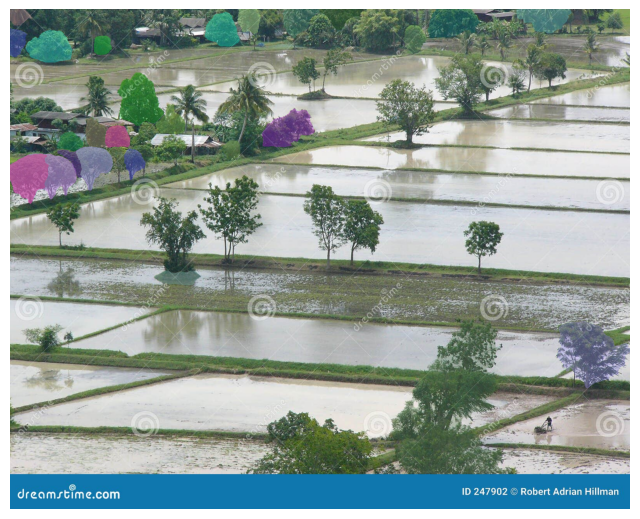

In [16]:
def show_anns(anns):
    """Plot all masks overlaid on the image"""
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=lambda x: x["area"], reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    
    for ann in sorted_anns:
        m = ann["segmentation"]
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        
        for i in range(3):
            img[:, :, i] = color_mask[i]  # Apply random color
        
        ax.imshow(np.dstack((img, m * 0.35)))  # Overlay masks

plt.figure(figsize=(8, 8))
plt.imshow(image)
show_anns(filtered_masks)
plt.axis("off")
plt.show()

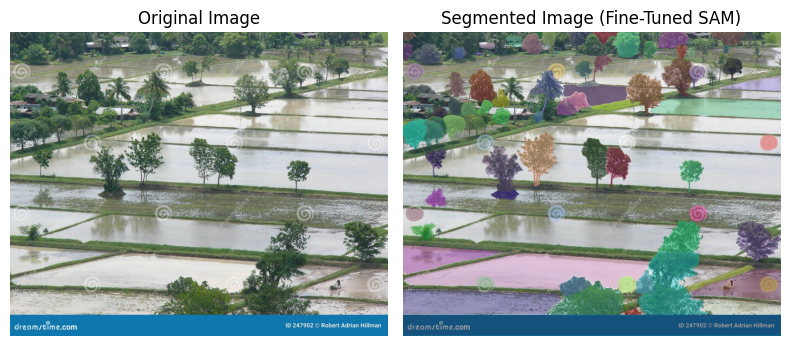

In [119]:
# Create figure with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(8, 8))

# Original Image
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Segmented Image
axes[1].imshow(image)  # Show original image as background
show_anns(masks)  # Overlay segmentation masks
axes[1].set_title("Segmented Image (Fine-Tuned SAM)")
axes[1].axis("off")

# Show visualization
plt.tight_layout()
plt.show()


## Comparison

In [120]:
model_name = "vit_b"
model_path = "/home/ubuntu/surface_water_detection/SAM-fine-tune/sam_vit_b_01ec64.pth"  

In [121]:
sam = sam_model_registry[model_name](checkpoint=model_path)
# sam.to(device="cuda" if torch.cuda.is_available() else "cpu")
sam.to(device="cpu")  # Use CPU for inference

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [122]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load image using PIL
test_img = Image.open("/home/ubuntu/surface_water_detection/SAM-fine-tune/SF_13.jpg")

In [123]:
test_img = test_img.convert("RGB")  # Ensure it's in RGB mode
test_img = np.array(test_img, dtype=np.uint8)  # Convert to NumPy array without unnecessary scaling
print("Input image dimensions: ", test_img.shape)
print(f"Min - Max values: [{np.min(test_img)} , {np.max(test_img)}] ")

Input image dimensions:  (1290, 1600, 3)
Min - Max values: [0 , 255] 


In [124]:
# Generate masks using SAM
mask_generator = SamAutomaticMaskGenerator(sam)
masks2 = mask_generator.generate(test_img)

In [125]:
def show_anns(anns):
    """Plot all masks overlaid on the image"""
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x["area"]), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for ann in sorted_anns:
        m = ann["segmentation"]
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = color_mask[i]
        ax.imshow(np.dstack((img, m * 0.35)))

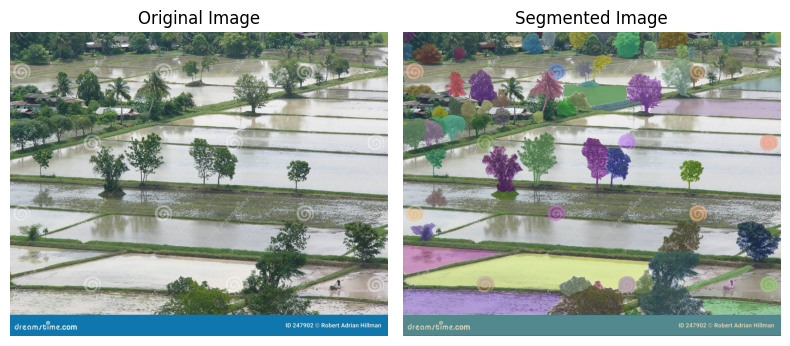

In [126]:
# Create a figure with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(8, 8))

# Original Image
axes[0].imshow(test_img)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Segmented Image
axes[1].imshow(test_img)  # Show original image as background
show_anns(masks2)  # Overlay segmentation masks
axes[1].set_title("Segmented Image")
axes[1].axis("off")

# Show the final visualization
plt.tight_layout()
plt.show()